In [11]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx


In [12]:
root = "./log_221005/"
path = Path(root)

In [22]:
tactic_paths = [x for x in path.iterdir() if x.is_dir()]
tactic_paths.sort()

x_list = []
y_int_list = []
y_atk_list = []

for tactic in range(len(tactic_paths)):
    
    attribute_paths = tactic_paths[tactic] / 'EntityAttributes_All.csv'
    entity_all = pd.read_csv(attribute_paths)
    x_list.append(entity_all)

    int_paths = tactic_paths[tactic] / 'SquadIntention_All.csv'
    y_int_all = pd.read_csv(int_paths)
    y_int_list.append(y_int_all)

    atk_paths = tactic_paths[tactic] / 'MunitionDetonation_All.csv'
    y_atk_all = pd.read_csv(atk_paths)
    y_atk_list.append(y_atk_all)


## TSNE

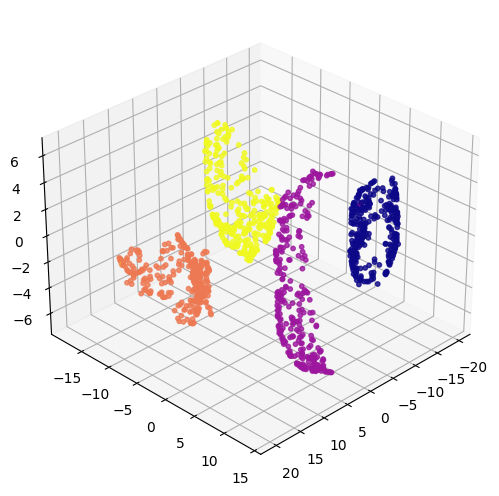

In [23]:
# mean x, for each combat 
x_mean = []
for x in x_list: x_mean.append(x.groupby(['combat_id', 'tactic_id']).mean())

# concat x, set tactic_id as index
x_concat = pd.concat(x_mean)
x_concat = x_concat.reset_index()
x_concat = x_concat.set_index('tactic_id')
x_concat = x_concat.drop(columns=['combat_id', 'SimulationTime(sec)'])

"""
3D tsne
"""
# 3D tsne x_concat, set tactic_id as color
tsne = TSNE(n_components=3, random_state=42)
x_tsne = tsne.fit_transform(x_concat)
x_tsne = pd.DataFrame(x_tsne, columns=['x', 'y', 'z'])
x_tsne['tactic_id'] = x_concat.index

# plot tsne
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_tsne['x'], x_tsne['y'], x_tsne['z'], c=x_tsne['tactic_id'], cmap='plasma', alpha=0.8, s=10)
ax.view_init(azim=45, elev=30)
plt.tight_layout()

## Trajectory

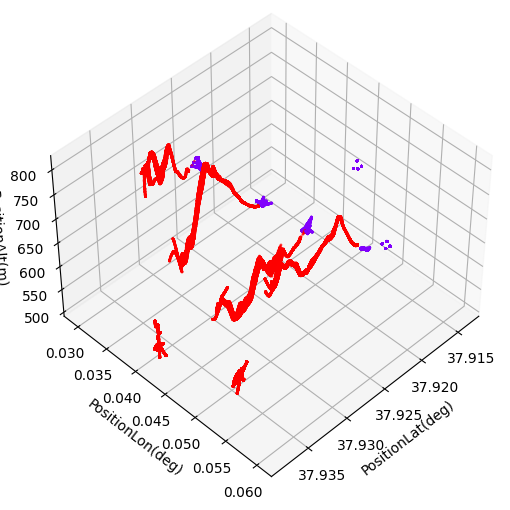

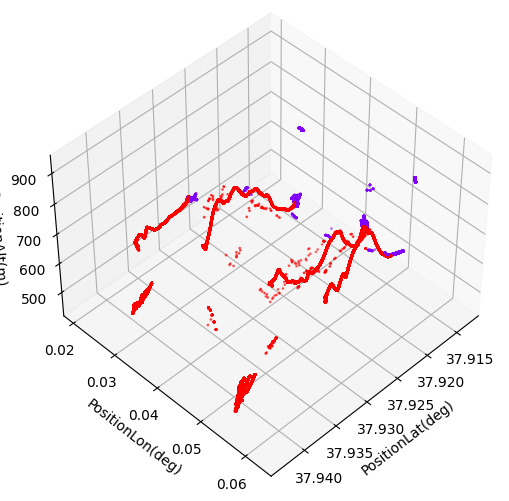

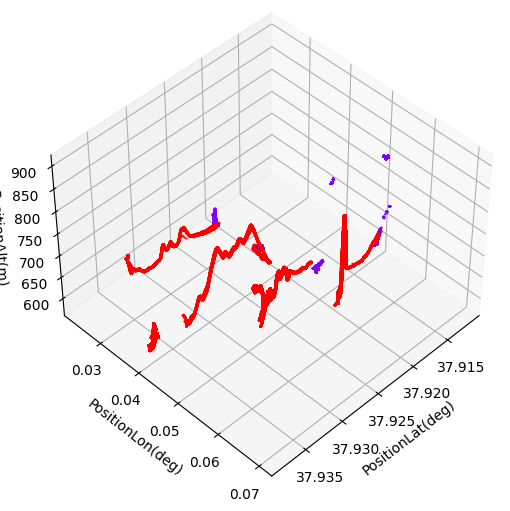

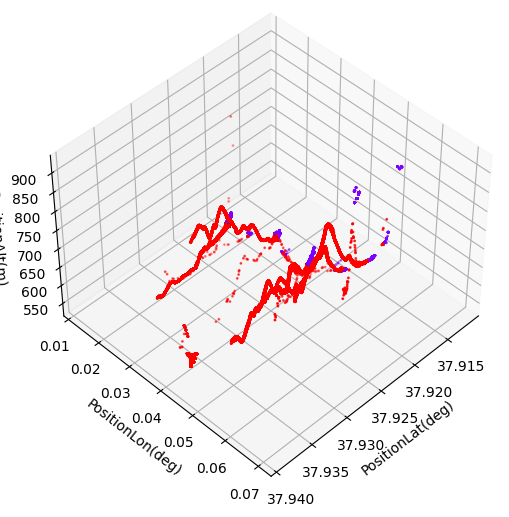

In [24]:

# visualize PositionLat(deg), PositionLon(deg), PositionAlt(m) distribution in 3D
entity_samples = []
for x in x_list: entity_samples.append(x.sample(frac=0.01, random_state=1))

for i in range(len(entity_samples)):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    # color is 'ForceIdentifier
    ax.scatter(entity_samples[i]['PositionLat(deg)'], 
               entity_samples[i]['PositionLon(deg)'], 
               entity_samples[i]['PositionAlt(m)'], 
               s=1,
               c=entity_samples[i]['ForceIdentifier'],
               cmap='rainbow'
               )
    
    ax.view_init(azim=45, elev=45)
    ax.set_xlabel('PositionLat(deg)')
    ax.set_ylabel('PositionLon(deg)')
    ax.set_zlabel('PositionAlt(m)')
    plt.tight_layout()

    plt.show()

## Statistics

In [26]:
y_int_list = [y_int[y_int['Status'] == 'Running '] for y_int in y_int_list]
print(y_int_list[0]['Intention'].value_counts(), '\n')
print(y_int_list[1]['Intention'].value_counts(), '\n')
print(y_int_list[2]['Intention'].value_counts(), '\n')
print(y_int_list[3]['Intention'].value_counts(), '\n')

Tactical Engagement       1236
Maneuvering Techniques    1236
Stategic Positioning       618
Coordinated Rendezvous     618
Name: Intention, dtype: int64 

Coordinated Rendezvous    1862
Maneuvering Techniques    1244
Stategic Positioning       622
Tactical Engagement          4
Name: Intention, dtype: int64 

Coordinated Rendezvous    1842
Stategic Surprise         1228
Stategic Positioning       614
Name: Intention, dtype: int64 

Coordinated Rendezvous    1866
Forceful Engagement       1550
Stategic Positioning       312
Stategic Surprise            4
Name: Intention, dtype: int64 



/tmp/ipykernel_3299655/635323053.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


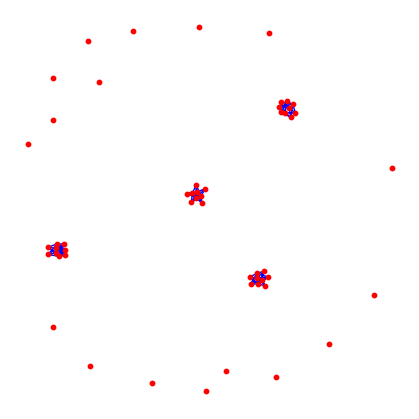

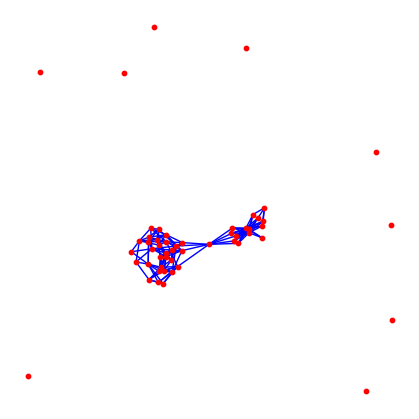

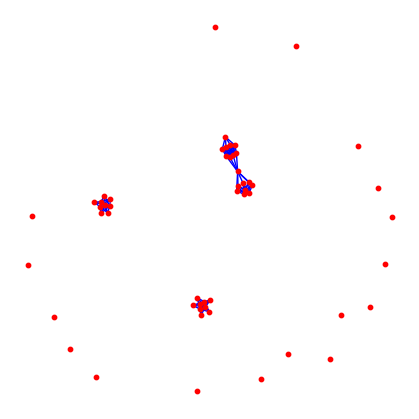

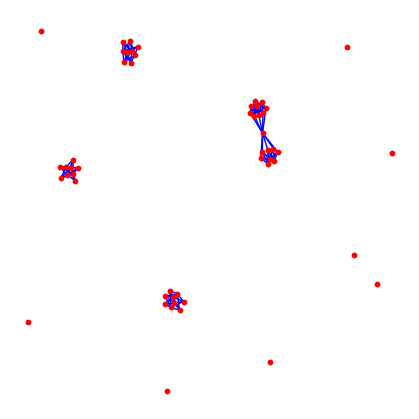

In [27]:
"""
visualize attack graph (edges are attack, nodes are entities)
"""

for y_atk in y_atk_list:

    source = y_atk['FiringObjectID']
    target = y_atk['TargetObjectID']

    all_nodes = np.arange(2, 55)

    G = nx.Graph()
    G.add_nodes_from(all_nodes)
    G.add_edges_from(zip(source, target))

    plt.figure(figsize=(4, 4))
    nx.draw(G, with_labels=False, node_size=10, font_size=3, node_color='r', edge_color='b', width=1.0)
    # tight
    plt.tight_layout()
    # title tactic     
    plt.show()


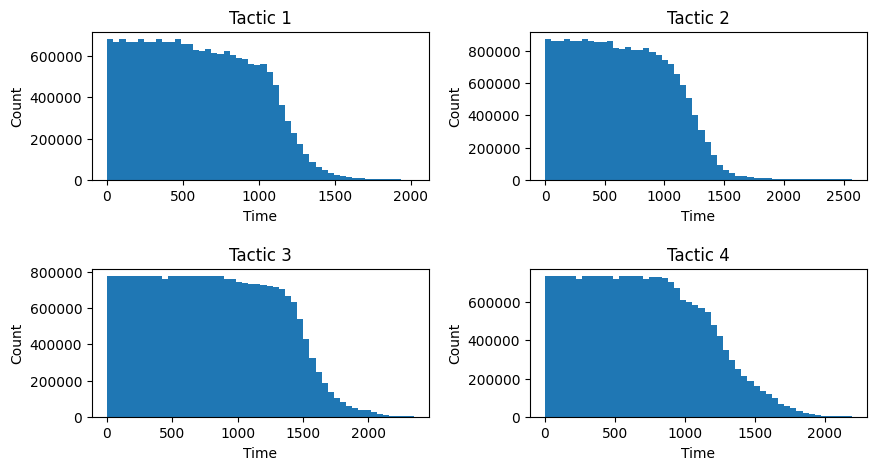

In [28]:
# visualize time distribution
plt.figure(figsize=(10, 5))
for i in range(len(x_list)):
    plt.subplot(2, 2, i+1)
    plt.hist(x_list[i]['SimulationTime(sec)'], bins=50)
    plt.title('Tactic {}'.format(i+1))
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()


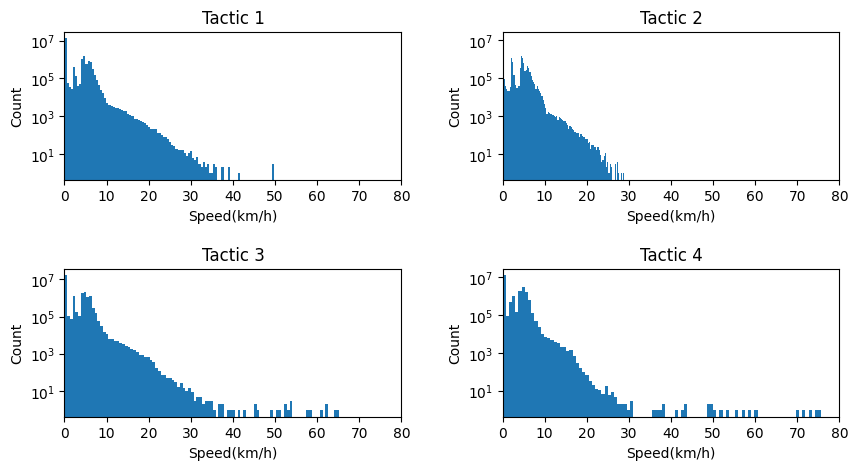

In [29]:
plt.figure(figsize=(10, 5))
for i in range(len(x_list)):
    plt.subplot(2, 2, i+1)
    plt.hist(x_list[i]['Speed(km/h)'], bins=100)
    plt.title('Tactic {}'.format(i+1))
    plt.xlabel('Speed(km/h)')
    plt.ylabel('Count')
    plt.subplots_adjust(wspace=0.3, hspace=0.6)
    plt.xlim(0, 80)
    plt.yscale('log')
plt.show()


In [30]:
for x in x_list: 
    x_static = x[x['SimulationTime(sec)'] == 2]
    print('Tactic {}'.format(x_static['tactic_id'].iloc[0]))
    print(x_static['ForceIdentifier'].value_counts())
    print()

Tactic 1
1    9270
0    7416
Name: ForceIdentifier, dtype: int64

Tactic 2
1    9330
0    7464
Name: ForceIdentifier, dtype: int64

Tactic 3
1    9210
0    7368
Name: ForceIdentifier, dtype: int64

Tactic 4
1    9330
0    7464
Name: ForceIdentifier, dtype: int64

